<a href="https://colab.research.google.com/github/BonaldSo/project_gan/blob/main/MyGANforMNISTdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os


# Setting the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 100
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

#ToDo: Build the train data loader using the above batch_size varibale and shuffling the dataset.
data_loader = DataLoader(train_dataset, batch_size, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 79076304.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 58889496.27it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21889057.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13568752.68it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Generator(nn.Module):
    def __init__(self, n_dim):
        super(Generator, self).__init__()
        #The activation function for the two hidden layers is ReLU.
        #The last layer's activation function is Tanh.
        self.fc1 = nn.Linear(n_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()


    def forward(self, x):
        #The function takes as input x and outputs the result of applying the generator on x.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.tanh(x)
        return x


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #The activation functions for the two hidden layers are ReLU.
        #The last layer's activation function is Sigmoid.
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1) # Making sure that the batch of images has the shape [batch_size,28*28] instead of [batch_size,1,28,28]
        #The function takes as input x and outputs the result of applying the generator on x.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


In [ ]:
n_dim = 100
generator = Generator(n_dim).to(device)
discriminator = Discriminator().to(device)
lr = 0.0002


criterion = nn.BCELoss()
#ToDo: define the two different Adam optimizers for generator and discriminator with learning rates of lr.

d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

In [ ]:
num_epochs = 30
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        real_images = images.to(device)

        # Training discriminator
        discriminator.zero_grad()
        real_outputs = discriminator(real_images)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        d_loss_real = criterion(real_outputs, real_labels)

        #ToDo: Compute d_loss_fake
        noise = torch.randn(batch_size, n_dim).to(device)
        fimage = generator(noise)
        foutput = discriminator(fimage.detach())
        flabel = torch.zeros(batch_size, 1).to(device)
        d_loss_fake = criterion(foutput, flabel)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Training generator
        generator.zero_grad()

        #ToDo: compute g_loss
        myfoutput = discriminator(fimage)
        g_loss = criterion(myfoutput, real_labels)


        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 300 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'Discriminator Loss: {d_loss.item():.4f}, '
                  f'Generator Loss: {g_loss.item():.4f}')

Epoch [1/30], Step [300/600], Discriminator Loss: 0.2267, Generator Loss: 4.0077
Epoch [1/30], Step [600/600], Discriminator Loss: 0.8389, Generator Loss: 3.1468
Epoch [2/30], Step [300/600], Discriminator Loss: 0.6616, Generator Loss: 2.4652
Epoch [2/30], Step [600/600], Discriminator Loss: 1.5059, Generator Loss: 1.3780
Epoch [3/30], Step [300/600], Discriminator Loss: 0.1482, Generator Loss: 2.9886
Epoch [3/30], Step [600/600], Discriminator Loss: 0.5106, Generator Loss: 3.1385
Epoch [4/30], Step [300/600], Discriminator Loss: 0.6059, Generator Loss: 3.0051
Epoch [4/30], Step [600/600], Discriminator Loss: 0.3776, Generator Loss: 3.0690
Epoch [5/30], Step [300/600], Discriminator Loss: 0.9257, Generator Loss: 1.5046
Epoch [5/30], Step [600/600], Discriminator Loss: 0.2512, Generator Loss: 3.2882
Epoch [6/30], Step [300/600], Discriminator Loss: 0.2331, Generator Loss: 3.2875
Epoch [6/30], Step [600/600], Discriminator Loss: 0.2941, Generator Loss: 3.6637
Epoch [7/30], Step [300/600]

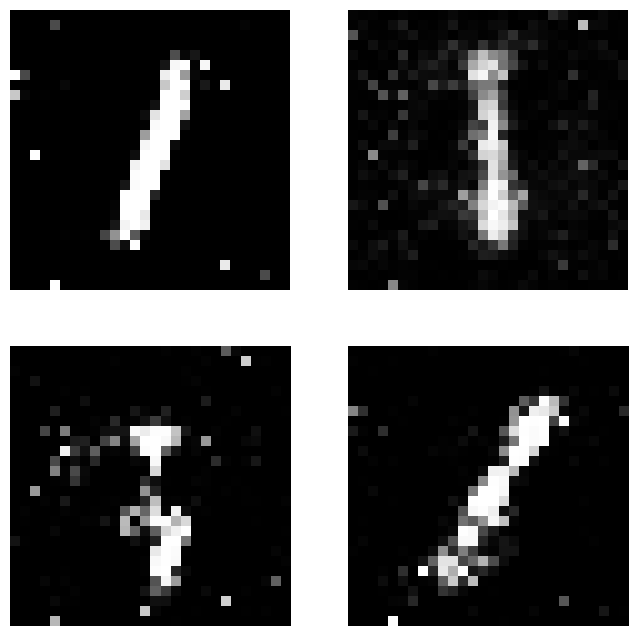

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

generator.eval()

with torch.no_grad():
    noise = torch.randn(4, n_dim).to(device)
    gimages = generator(noise).cpu().numpy()

f, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, a in enumerate(ax.flatten()):
    a.imshow(gimages[i].reshape(28, 28), cmap='gray')
    a.axis('off')
plt.show()